In [ ]:
!pip install pycatch22

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycatch22: filename=pycatch22-0.4.5-cp311-cp311-linux_x86_64.whl size=113655 sha256=a3919dce8f1e4189a70388c73e1b5f5ac92156ed2364c8d3f789cddd2c98e39a
  Stored in directory: /root/.cache/pip/wheels/79/9b/3d/e6f1189c5a4a3ff41788a9e37ced0cd0cb0d2af46974aadfbb
Successfully built pycatch22


In [ ]:
!pip install --upgrade xgboost

In [ ]:
# =====================================
# EEG Classifier (Catch22 features + RF/SVM/XGBoost)
# Memory Classifier: Five vs Nine vs Thirteen
# Binary Classifier: JustListen vs Memory
# Four-class classifier JustListen vs Five vs Nine vs Thirteen
# =====================================

import numpy as np
import pickle
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_importance
from imblearn.over_sampling import RandomOverSampler
from joblib import dump
from tqdm import tqdm
from scipy.signal import resample
from pycatch22 import catch22_all

warnings.filterwarnings("ignore")
np.random.seed(42)


In [ ]:
# === Load EEG data ===
with open("/content/drive/MyDrive/output_eeg_data/processed_eeg_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

data = data_dict["data"]  # EEG: Shape (65, 3, 3, 54, 26000)

print(f"✅ EEG data shape: {data.shape}")

# === Utility functions ===
def clean_signals(X):
    X = np.nan_to_num(X)
    return (X - np.mean(X, axis=1, keepdims=True)) / (np.std(X, axis=1, keepdims=True) + 1e-8)

def downsample_signals(X, target_len=6000):
    return np.array([resample(sig, target_len) for sig in X])

def extract_features(X_signals):
    return np.array([catch22_all(sig)["values"] for sig in tqdm(X_signals, desc="🔍 Extracting Catch22")])

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def plot_roc_auc(y_true, y_prob, n_classes, title="ROC Curve"):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(8,6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

✅ EEG data shape: (65, 3, 3, 54, 26000)


In [ ]:
def train_classifier(X, y, label_names, model, model_name, is_binary=False):
    print(f"\n⚙️ Training classifier: {model_name}")

    # Fix y labels to be 1D
    y = np.array(y).ravel()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
    ros = RandomOverSampler(random_state=42)
    X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

    # Cross-Validation
    print("\n🔎 Performing 5-Fold Cross-Validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_res, y_train_res, cv=cv, scoring="accuracy", n_jobs=-1)
    print(f"✅ Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    start_time = time.time()

    model.fit(X_train_res, y_train_res)

    end_time = time.time()
    print(f"⏱️ Training Time: {end_time - start_time:.2f} seconds")

    y_pred = model.predict(X_test)
    y_pred = np.array(y_pred).ravel()   # Flatten prediction

    y_proba = model.predict_proba(X_test)

    # Now everything is clean 1D for metrics
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ Test Accuracy: {acc:.4f}")
    print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=label_names))

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, labels=label_names, title=f"{model_name} - Confusion Matrix")

    # ROC
    if is_binary:
        if y_proba.shape[1] == 2:
            positive_class_probs = y_proba[:, 1]
        else:
            positive_class_probs = y_proba.ravel()  # in case it's weirdly shaped

        roc_auc = roc_auc_score(y_test, positive_class_probs)
        fpr, tpr, _ = roc_curve(y_test, positive_class_probs)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{model_name} - ROC Curve")
        plt.legend()
        plt.show()
    else:
        plot_roc_auc(y_test, y_proba, n_classes=len(label_names), title=f"{model_name} - ROC Curve")


    # Feature Importance
    if isinstance(model, RandomForestClassifier):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1][:10]
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(indices)), importances[indices], align="center")
        plt.xticks(range(len(indices)), [f"Feature {i}" for i in indices], rotation=45)
        plt.title(f"{model_name} - Top 10 Feature Importances")
        plt.show()

    elif isinstance(model, XGBClassifier):
        plt.figure(figsize=(10, 6))
        plot_importance(model, max_num_features=10)
        plt.title(f"{model_name} - Top 10 Feature Importances")
        plt.show()

    # Save model
    dump(model, f"{model_name}.joblib")
    print(f"✅ Model saved as '{model_name}.joblib'")


📉 Normalizing and downsampling EEG memory signals...
✅ Shape after downsampling - EEG X_mem: (6660, 6000)

🔄 Extracting Catch22 features for EEG memory classifier...


🔍 Extracting Catch22: 100%|██████████| 6660/6660 [09:29<00:00, 11.69it/s]



⚙️ Training classifier: EEG_memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9977 ± 0.0008
⏱️ Training Time: 1.80 seconds

✅ Test Accuracy: 1.0000

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       1.00      1.00      1.00       590
    Nine-Memory       1.00      1.00      1.00       560
Thirteen-Memory       1.00      1.00      1.00       515

       accuracy                           1.00      1665
      macro avg       1.00      1.00      1.00      1665
   weighted avg       1.00      1.00      1.00      1665



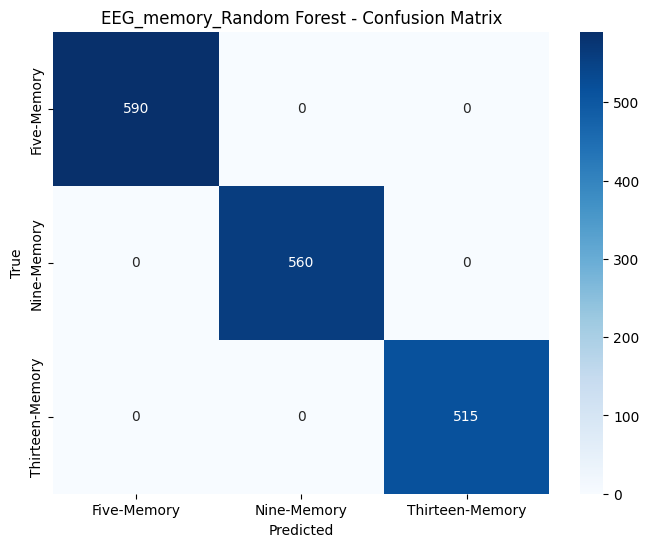

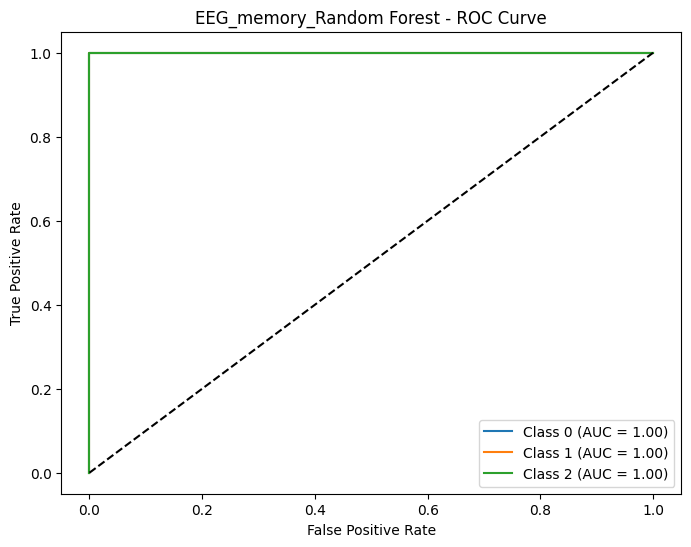

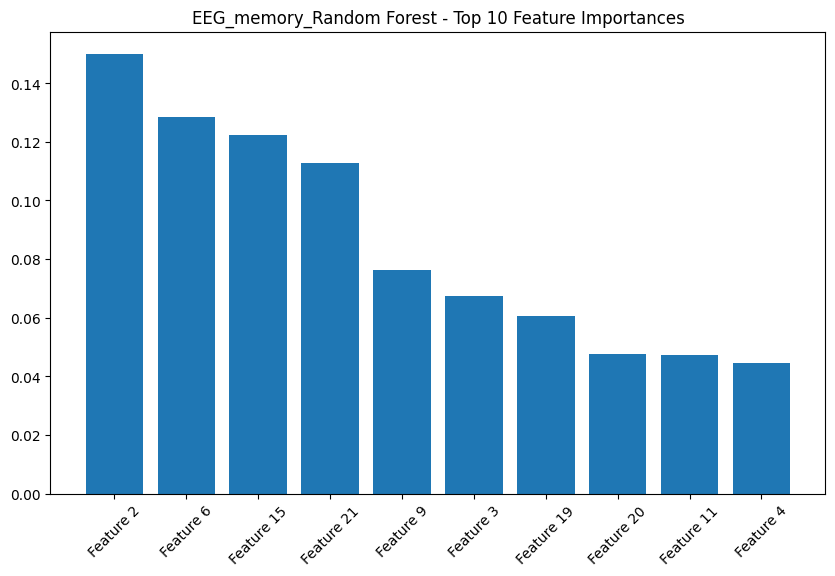

✅ Model saved as 'EEG_memory_Random Forest.joblib'

⚙️ Training classifier: EEG_memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9823 ± 0.0042
⏱️ Training Time: 0.89 seconds

✅ Test Accuracy: 0.9862

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       0.99      1.00      0.99       590
    Nine-Memory       1.00      0.96      0.98       560
Thirteen-Memory       0.96      1.00      0.98       515

       accuracy                           0.99      1665
      macro avg       0.99      0.99      0.99      1665
   weighted avg       0.99      0.99      0.99      1665



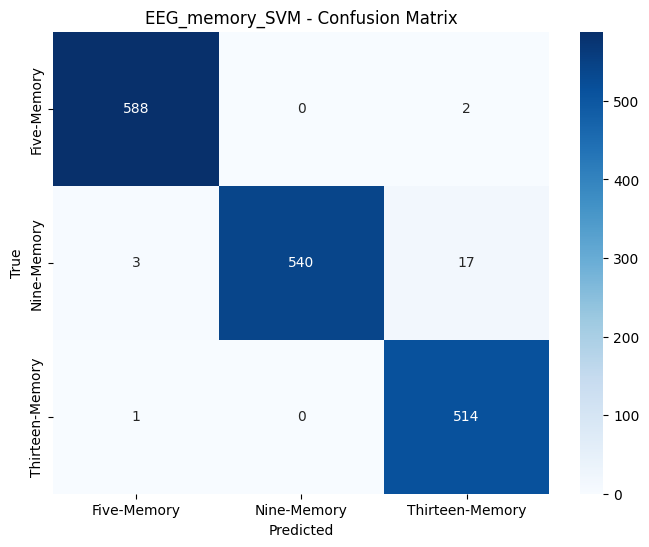

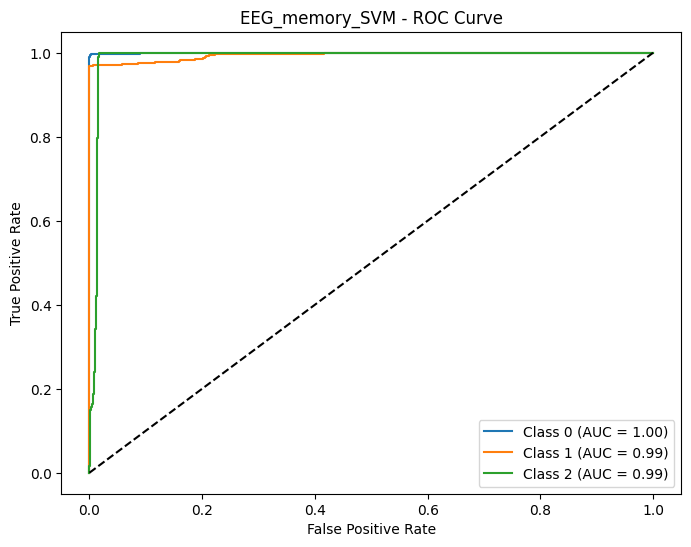

✅ Model saved as 'EEG_memory_SVM.joblib'

⚙️ Training classifier: EEG_memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.9983 ± 0.0014
⏱️ Training Time: 0.92 seconds

✅ Test Accuracy: 0.9982

✅ Classification Report:
                  precision    recall  f1-score   support

    Five-Memory       1.00      1.00      1.00       590
    Nine-Memory       0.99      1.00      1.00       560
Thirteen-Memory       1.00      1.00      1.00       515

       accuracy                           1.00      1665
      macro avg       1.00      1.00      1.00      1665
   weighted avg       1.00      1.00      1.00      1665



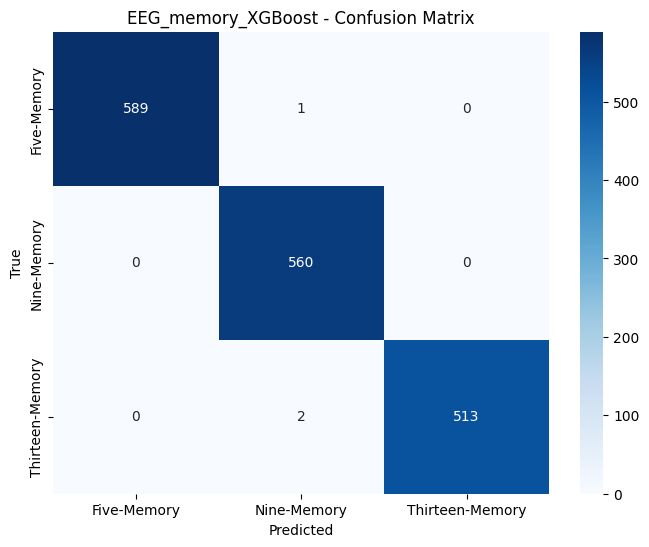

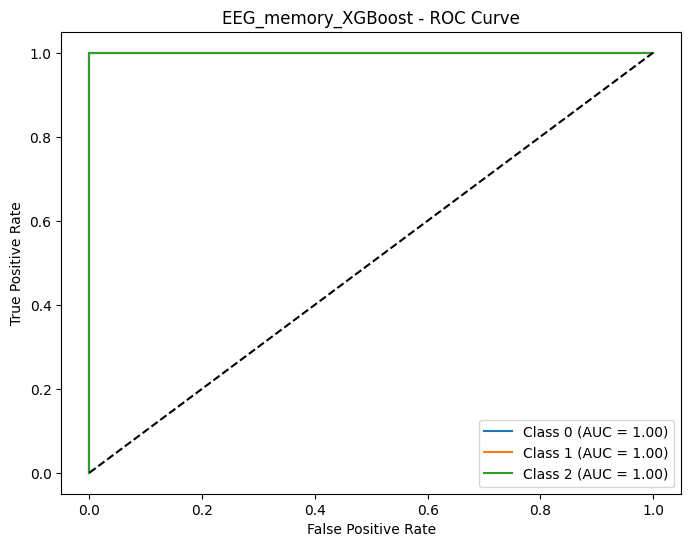

<Figure size 1000x600 with 0 Axes>

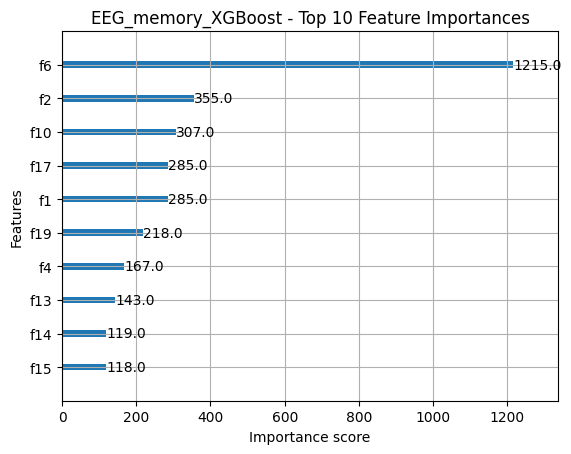

✅ Model saved as 'EEG_memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for Memory Classifier (EEG) ===
X_mem, y_mem = [], []
memory_label_map = {
    "Five-Memory": 0,
    "Nine-Memory": 1,
    "Thirteen-Memory": 2
}

for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in [1, 2]:  # Memory Correct, Memory Incorrect
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = f"{condition}-Memory"
                    X_mem.append(signal)
                    y_mem.append(memory_label_map[label])

X_mem = np.array(X_mem)
print("📉 Normalizing and downsampling EEG memory signals...")
X_mem = clean_signals(X_mem)
X_mem = downsample_signals(X_mem, target_len=6000)  # EEG: Downsample to 2000
print("✅ Shape after downsampling - EEG X_mem:", X_mem.shape)

print("\n🔄 Extracting Catch22 features for EEG memory classifier...")
X_mem_features = extract_features(X_mem)

# === Models ===
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=300, max_depth=8, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=300, max_depth=6, learning_rate=0.05,
        objective="multi:softprob", num_class=3, random_state=42, n_jobs=-1
    ),
}

# === Train models for EEG memory classification ===
for model_name, model in models.items():
    train_classifier(X_mem_features, np.array(y_mem), list(memory_label_map.keys()), model, f"EEG_memory_{model_name}", is_binary=False)


📉 Normalizing and downsampling EEG binary signals...
✅ Shape after downsampling - EEG X_jm: (9737, 6000)

🔄 Extracting Catch22 features for EEG binary classifier...


🔍 Extracting Catch22: 100%|██████████| 9737/9737 [13:32<00:00, 11.99it/s]



⚙️ Training classifier: EEG_justlisten_vs_memory_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.6193 ± 0.0177
⏱️ Training Time: 9.39 seconds

✅ Test Accuracy: 0.5552

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.30      0.31      0.31       769
      Memory       0.68      0.67      0.67      1666

    accuracy                           0.56      2435
   macro avg       0.49      0.49      0.49      2435
weighted avg       0.56      0.56      0.56      2435



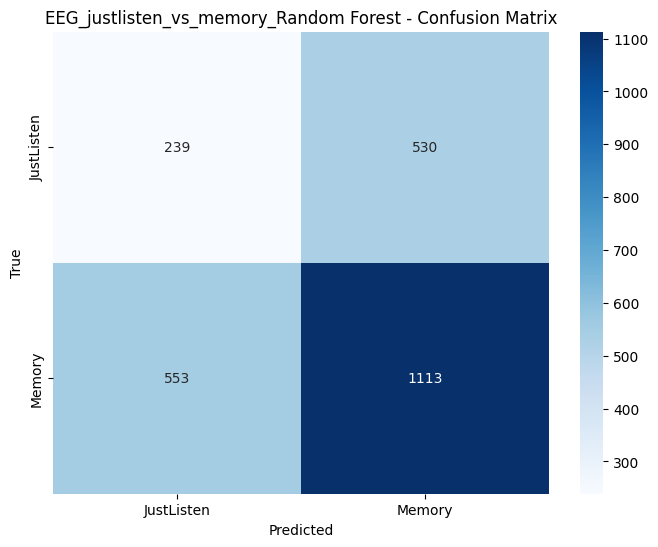

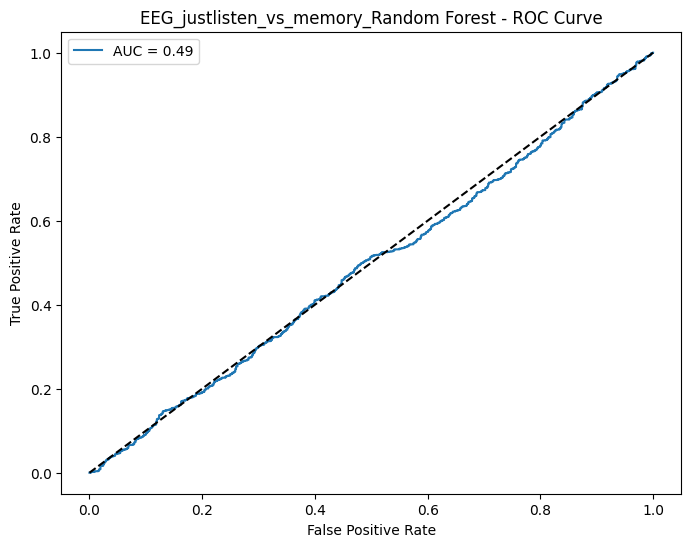

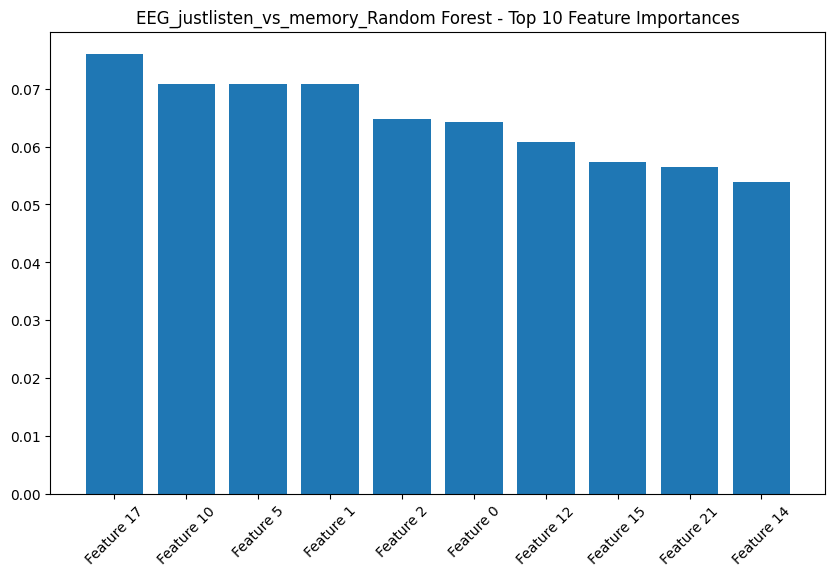

✅ Model saved as 'EEG_justlisten_vs_memory_Random Forest.joblib'

⚙️ Training classifier: EEG_justlisten_vs_memory_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.5030 ± 0.0071
⏱️ Training Time: 44.09 seconds

✅ Test Accuracy: 0.6086

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.32      0.21      0.25       769
      Memory       0.68      0.79      0.74      1666

    accuracy                           0.61      2435
   macro avg       0.50      0.50      0.49      2435
weighted avg       0.57      0.61      0.58      2435



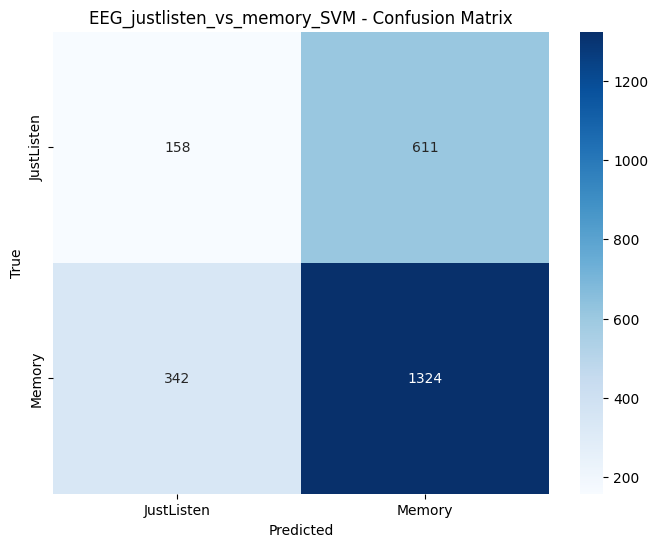

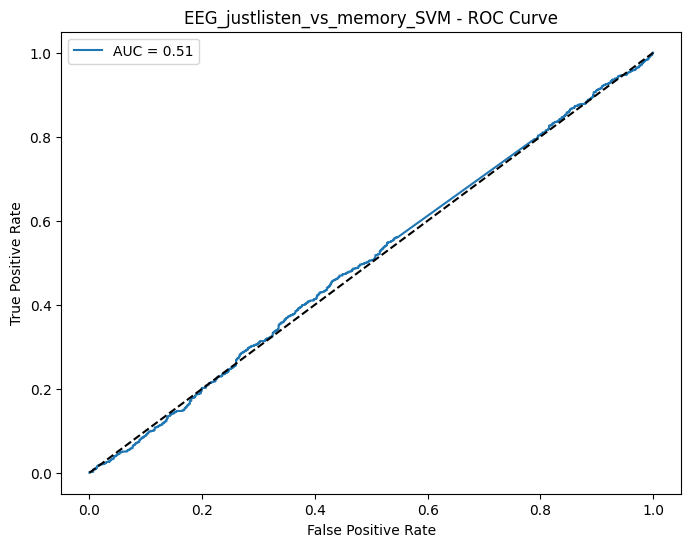

✅ Model saved as 'EEG_justlisten_vs_memory_SVM.joblib'

⚙️ Training classifier: EEG_justlisten_vs_memory_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7269 ± 0.0039
⏱️ Training Time: 1.58 seconds

✅ Test Accuracy: 0.5754

✅ Classification Report:
               precision    recall  f1-score   support

  JustListen       0.31      0.29      0.30       769
      Memory       0.68      0.71      0.70      1666

    accuracy                           0.58      2435
   macro avg       0.50      0.50      0.50      2435
weighted avg       0.57      0.58      0.57      2435



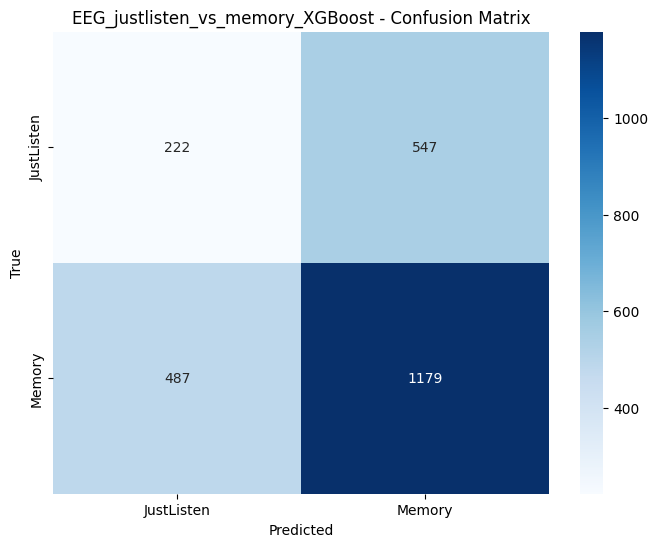

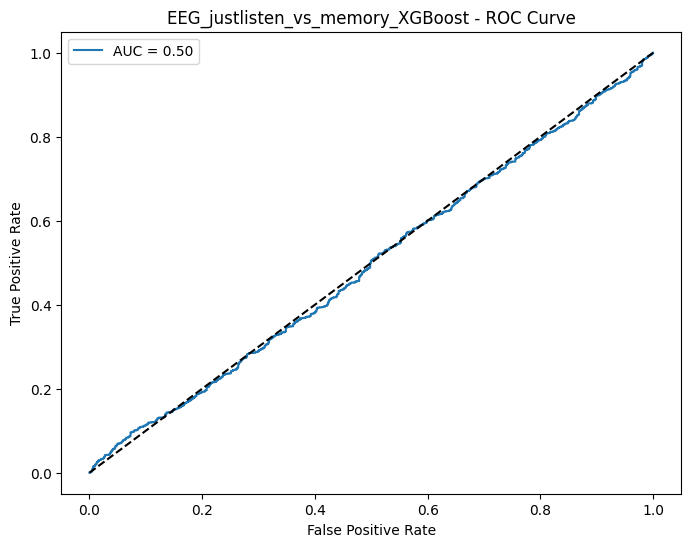

<Figure size 1000x600 with 0 Axes>

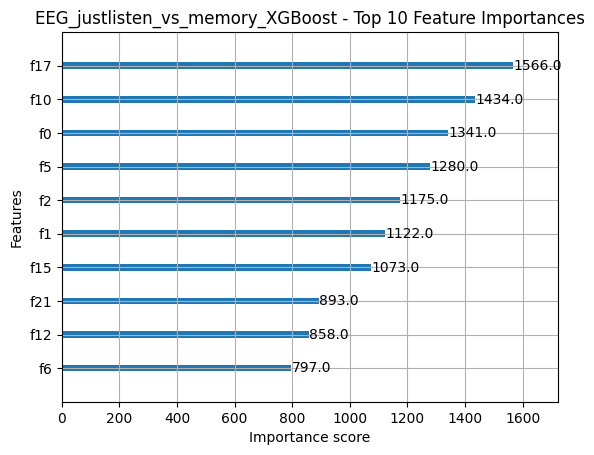

✅ Model saved as 'EEG_justlisten_vs_memory_XGBoost.joblib'


In [ ]:
# === Data Preparation for JustListen vs Memory Classifier (EEG) ===
X_jm, y_jm = [], []
for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for subcond_idx in range(3):  # JustListen = 0, Memory Correct = 1, Memory Incorrect = 2
            for trial_idx in range(54):
                signal = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(signal).all():
                    label = 0 if subcond_idx == 0 else 1  # 0: JustListen, 1: Memory (either correct/incorrect)
                    X_jm.append(signal)
                    y_jm.append(label)

X_jm = np.array(X_jm)
print("\n📉 Normalizing and downsampling EEG binary signals...")
X_jm = clean_signals(X_jm)
X_jm = downsample_signals(X_jm, target_len=6000)
print("✅ Shape after downsampling - EEG X_jm:", X_jm.shape)

print("\n🔄 Extracting Catch22 features for EEG binary classifier...")
X_jm_features = extract_features(X_jm)

# === Models for JustListen vs Memory Classifier ===
binary_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=8, min_samples_split=5, min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=6, learning_rate=0.05,
        objective="binary:logistic", random_state=42, n_jobs=-1
    ),
}

# === Train models for EEG binary classification ===
for model_name, model in binary_models.items():
    train_classifier(X_jm_features, np.array(y_jm), ["JustListen", "Memory"], model, f"EEG_justlisten_vs_memory_{model_name}", is_binary=True)


📉 Normalizing and downsampling EEG signals for 4-class classifier...
✅ Shape after downsampling - EEG X_4class: (9737, 2000)

🔄 Extracting Catch22 features for EEG four-class classifier...



🔍 Extracting Catch22: 100%|██████████| 9737/9737 [03:11<00:00, 50.79it/s]



⚙️ Training classifier: EEG_fourclass_Random Forest

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7463 ± 0.0012
⏱️ Training Time: 12.88 seconds

✅ Test Accuracy: 0.6768

✅ Classification Report:
                  precision    recall  f1-score   support

     JustListen       0.36      0.01      0.02       770
    Five-Memory       0.69      0.99      0.81       590
    Nine-Memory       0.67      0.98      0.80       560
Thirteen-Memory       0.68      0.99      0.80       515

       accuracy                           0.68      2435
      macro avg       0.60      0.74      0.61      2435
   weighted avg       0.58      0.68      0.56      2435



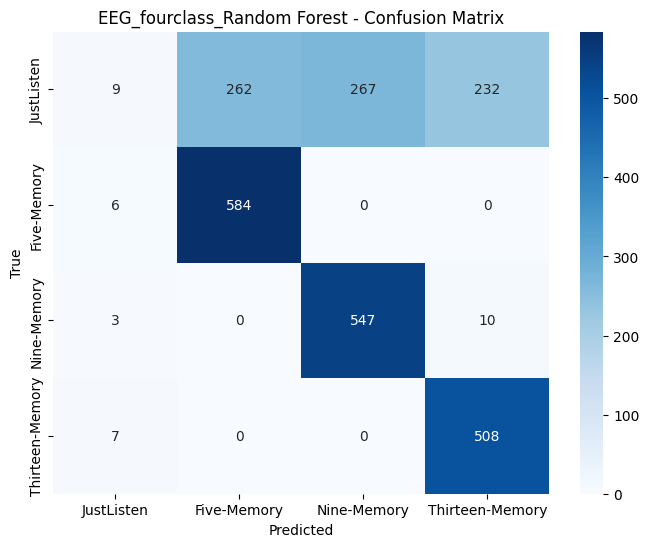

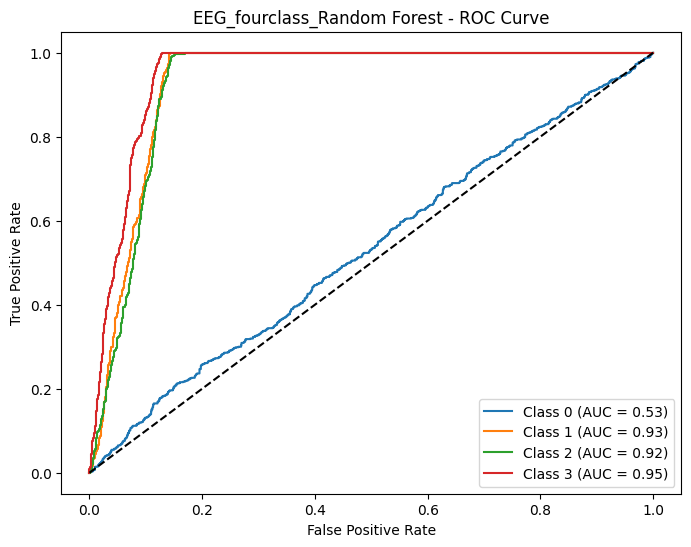

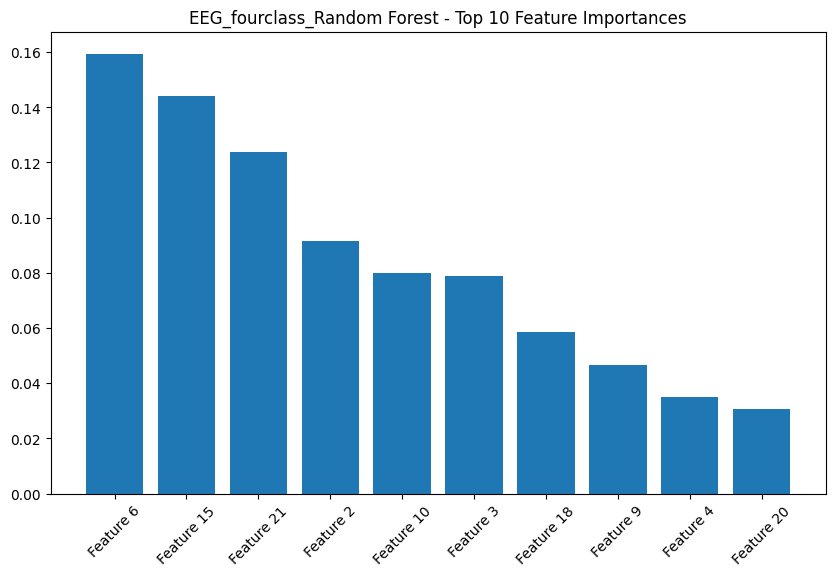

✅ Model saved as 'EEG_fourclass_Random Forest.joblib'

⚙️ Training classifier: EEG_fourclass_SVM

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7308 ± 0.0024
⏱️ Training Time: 14.40 seconds

✅ Test Accuracy: 0.6674

✅ Classification Report:
                  precision    recall  f1-score   support

     JustListen       0.40      0.00      0.01       770
    Five-Memory       0.68      0.99      0.81       590
    Nine-Memory       0.66      0.96      0.78       560
Thirteen-Memory       0.66      0.97      0.79       515

       accuracy                           0.67      2435
      macro avg       0.60      0.73      0.60      2435
   weighted avg       0.58      0.67      0.54      2435



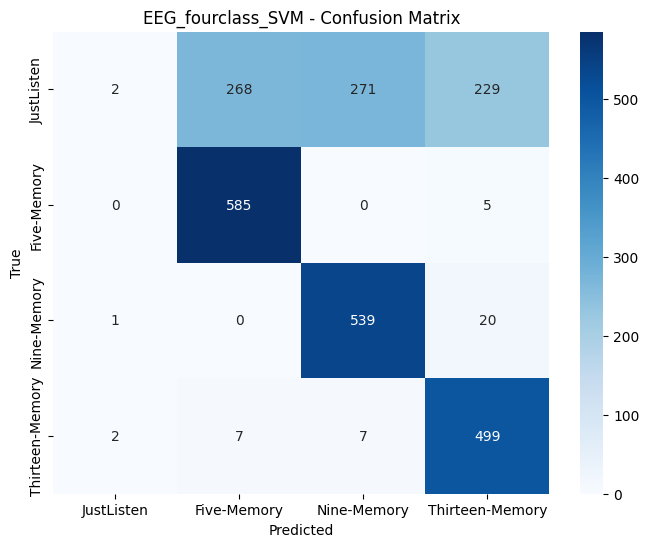

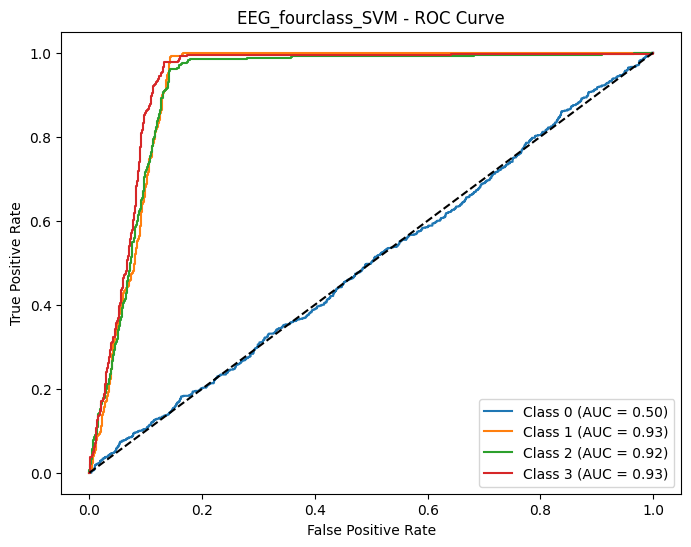

✅ Model saved as 'EEG_fourclass_SVM.joblib'

⚙️ Training classifier: EEG_fourclass_XGBoost

🔎 Performing 5-Fold Cross-Validation...
✅ Cross-Validation Accuracy: 0.7279 ± 0.0065
⏱️ Training Time: 15.46 seconds

✅ Test Accuracy: 0.6394

✅ Classification Report:
                  precision    recall  f1-score   support

     JustListen       0.33      0.12      0.18       770
    Five-Memory       0.69      0.87      0.77       590
    Nine-Memory       0.68      0.88      0.76       560
Thirteen-Memory       0.68      0.89      0.77       515

       accuracy                           0.64      2435
      macro avg       0.59      0.69      0.62      2435
   weighted avg       0.57      0.64      0.58      2435



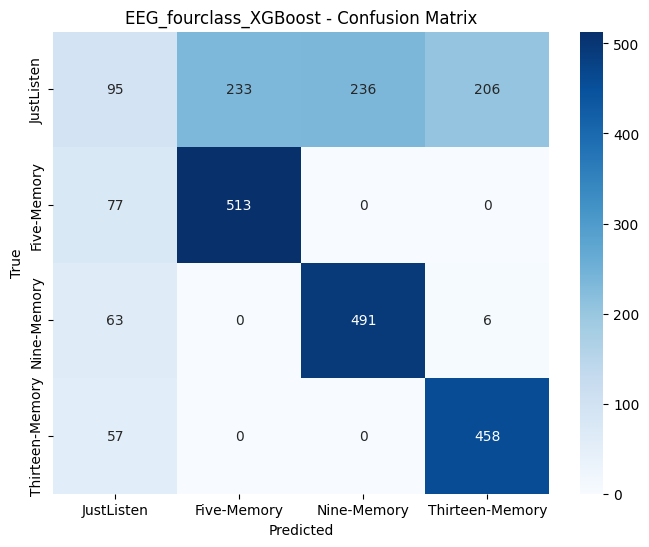

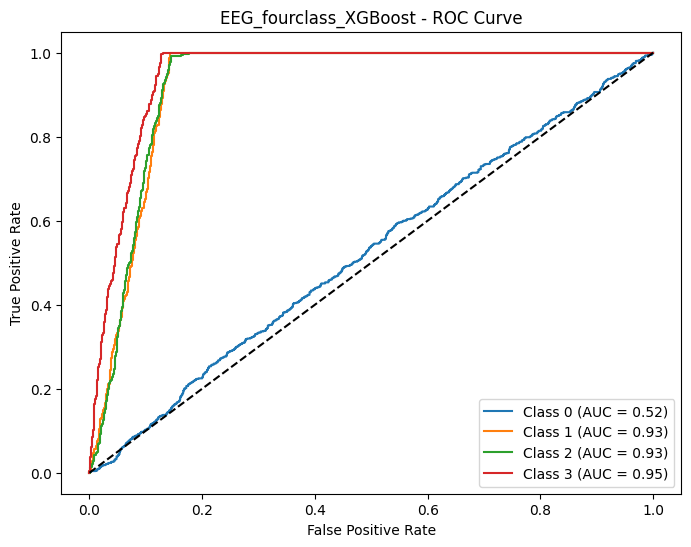

<Figure size 1000x600 with 0 Axes>

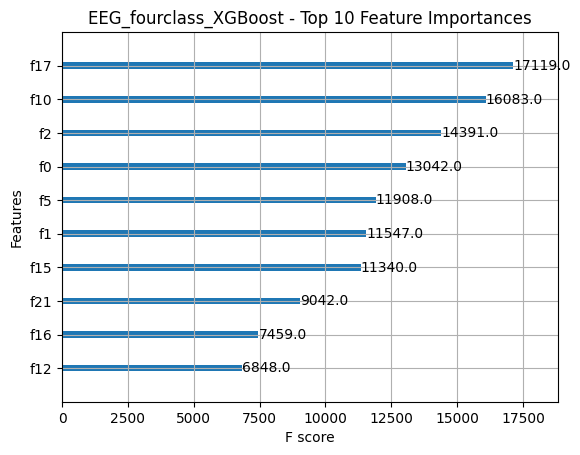

✅ Model saved as 'EEG_fourclass_XGBoost.joblib'


In [ ]:
# === Data Preparation for Four-Class Classifier (EEG) ===
X_4class, y_4class = [], []
fourclass_label_map = {
    "JustListen": 0,
    "Five-Memory": 1,
    "Nine-Memory": 2,
    "Thirteen-Memory": 3
}

for subj_data in data:
    for cond_idx, condition in enumerate(["Five", "Nine", "Thirteen"]):
        for trial_idx in range(54):
            # JustListen trial
            sig_jl = subj_data[cond_idx, 0, trial_idx, :]
            if not np.isnan(sig_jl).all():
                X_4class.append(sig_jl)
                y_4class.append(0)

            # Memory trials (Correct + Incorrect)
            for subcond_idx in [1, 2]:
                sig_mem = subj_data[cond_idx, subcond_idx, trial_idx, :]
                if not np.isnan(sig_mem).all():
                    label = f"{condition}-Memory"
                    X_4class.append(sig_mem)
                    y_4class.append(fourclass_label_map[label])

X_4class = np.array(X_4class)
print("\n📉 Normalizing and downsampling EEG signals for 4-class classifier...")
X_4class = clean_signals(X_4class)
X_4class = downsample_signals(X_4class, target_len=2000)
print("✅ Shape after downsampling - EEG X_4class:", X_4class.shape)

print("\n🔄 Extracting Catch22 features for EEG four-class classifier...")
X_4class_features = extract_features(X_4class)

label_names_4class = list(fourclass_label_map.keys())

# === Models for 4-Class Classifier ===
fourclass_models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, max_depth=10, min_samples_split=5, bootstrap=False, max_features='sqrt', min_samples_leaf=2,
        class_weight="balanced", random_state=42, n_jobs=-1
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
    "XGBoost": XGBClassifier(
        n_estimators=500, max_depth=10, learning_rate=0.05,
        objective="multi:softprob", random_state=42, n_jobs=-1
    ),
}

# === Train models for EEG 4-class classification ===
for model_name, model in fourclass_models.items():
    train_classifier(X_4class_features, np.array(y_4class), label_names_4class, model, f"EEG_fourclass_{model_name}", is_binary=False)